In [2]:
from funciones import *
import matplotlib.pyplot as plt
from logger import *


"""
Metricas para SOLO VNS
"""

def error_relativo(valor_medio, mejor_valor):
    re = ( (valor_medio - mejor_valor) / mejor_valor) * 100
    return re

def coeficiente_variacion(std, mean):
    """
    generar histograma para cada problema 25,90,150
    """
    cv = (std / mean) * 100
    return cv


"""
Extrae datos del logger, calcula errores relativos y llama a funciones de visualización.

:param logger: instancia de Logger con .data cargado
:param valor_optimo_dict: diccionario con el mejor valor conocido por dataset, ej:
        {'tai25b.dat': 344355646, 'sko90b.dat': 115534, 'tai150b.dat': 498896643}
"""
logger = Logger("resultados/COMPLETO.csv", False)

if logger.data is None:
    raise Exception("No se han cargado los datos del CSV")



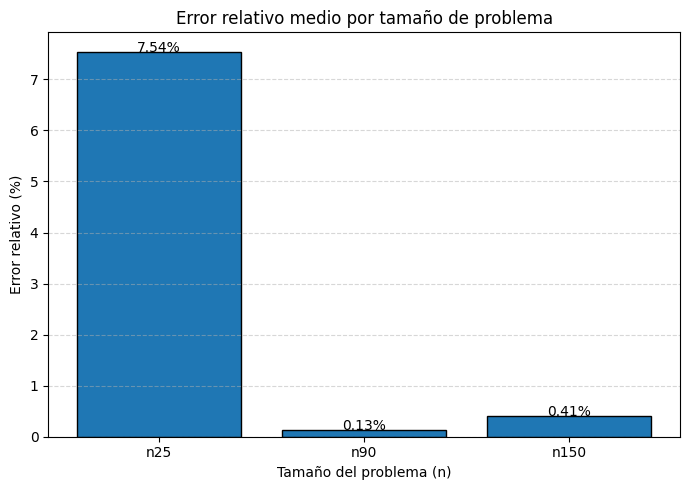

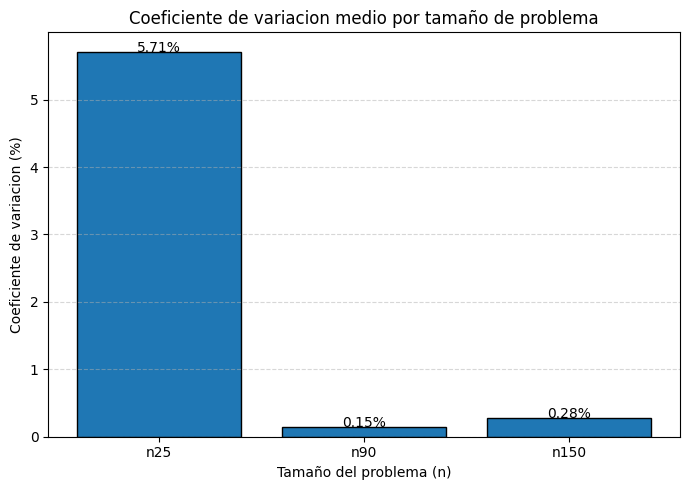

In [3]:
"""

GRAFICO BARRAS DEL ERROR RELATIVO Y COEFICIENTE DE VARIACION

"""
df_vns = logger.data[logger.data['Algoritmo'] == 'VNS']

vns_data = {
    'n25': df_vns[df_vns['Dataset'].str.contains("tai25")][['Costo', 'Evaluaciones']],
    'n90': df_vns[df_vns['Dataset'].str.contains("sko90")][['Costo', 'Evaluaciones']],
    'n150': df_vns[df_vns['Dataset'].str.contains("tai150")][['Costo', 'Evaluaciones']]
}

vns_stats = dict()
valores_er = []
valores_cv = []
xlabels = []
mean_evaluaciones = []

for clave, grupo in vns_data.items():
    
    costos = grupo['Costo'].astype(float).values  # Asegurar tipo numérico

    if len(costos) == 0:
        continue  # Saltar si no hay datos

    xlabels.append(clave)

    stats = {
        'n': clave,
        'mean': np.mean(costos),
        'std': np.std(costos),
        'minimum': np.min(costos),
        'maximum': np.max(costos)
    }
    
    mean_evaluaciones.append(np.mean(grupo['Evaluaciones'].astype(float).values))

    vns_stats[clave] = stats

    valores_er.append(error_relativo(stats['mean'], stats['minimum']))
    valores_cv.append(coeficiente_variacion(stats['std'], stats['mean']))

plt.figure(figsize=(7, 5))
plt.bar(xlabels, valores_er, edgecolor='black')
# Etiquetas y estilo
plt.title("Error relativo medio por tamaño de problema")
plt.xlabel("Tamaño del problema (n)")
plt.ylabel("Error relativo (%)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
# Etiquetas encima de las barras
for i, v in enumerate(valores_er):
    plt.text(i, v, f"{v:.2f}%", ha='center')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.bar(xlabels, valores_cv, edgecolor='black')
# Etiquetas y estilo
plt.title("Coeficiente de variacion medio por tamaño de problema")
plt.xlabel("Tamaño del problema (n)")
plt.ylabel("Coeficiente de variacion (%)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
# Etiquetas encima de las barras
for i, v in enumerate(valores_cv):
    plt.text(i, v, f"{v:.2f}%", ha='center')
plt.tight_layout()
plt.show()

Regresión log-log:
log(E) = -1.6934 + 3.6299 · log(n)
=> E ≈ exp(-1.6934) · n^3.6299


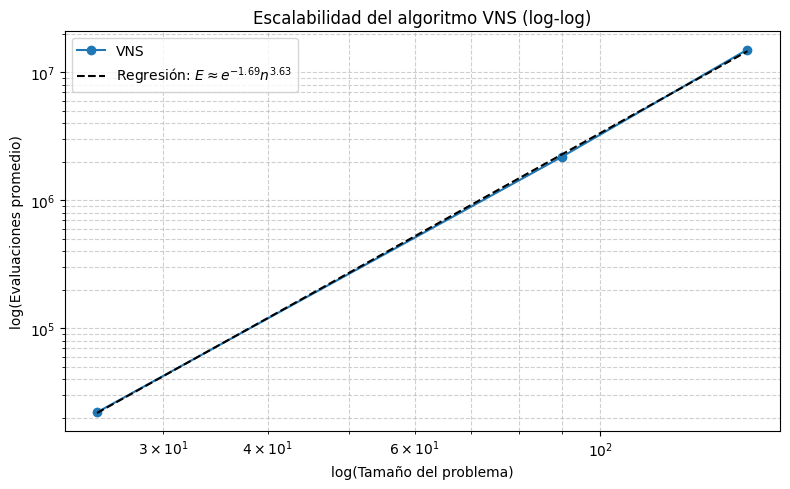

In [5]:
"""

GRAFICO ESCALABILIDAD
"""

S = np.array([25, 90, 150])
E = np.array(mean_evaluaciones)

def ajustar_regresion_loglog(S, E):
    """
    Calcula los parámetros de regresión log-log: log(E) = _alpha + _beta * log(n)
    :param S: array de tamaños de problema (n)
    :param E: array de evaluaciones promedio
    :return: (alpha, beta)
    """
    logS = np.log(S)
    logE = np.log(E)

    # Ajuste lineal: log(E) = β·log(n) + α
    beta, alpha = np.polyfit(logS, logE, 1)

    print(f"Regresión log-log:")
    print(f"log(E) = {alpha:.4f} + {beta:.4f} · log(n)")
    print(f"=> E ≈ exp({alpha:.4f}) · n^{beta:.4f}")

    return alpha, beta

alpha, beta = ajustar_regresion_loglog(S, E)

"""
# Graficar
plt.figure(figsize=(8, 5))
plt.loglog(S, E, 'o-', label='VNS')
plt.xlabel("log(Tamaño del problema)")
plt.ylabel("log(Evaluaciones promedio)")
plt.title("Escalabilidad del algoritmo VNS (log-log)")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
"""

logS = np.log(S)
logE = np.log(E)
beta, alpha = np.polyfit(logS, logE, 1)
E_pred = np.exp(alpha) * S ** beta


# Gráfico con tu estilo
plt.figure(figsize=(8, 5))
plt.loglog(S, E, 'o-', label='VNS')  # puntos y líneas conectadas
plt.loglog(S, E_pred, 'k--', label=f'Regresión: $E \\approx e^{{{alpha:.2f}}} n^{{{beta:.2f}}}$')

plt.xlabel("log(Tamaño del problema)")
plt.ylabel("log(Evaluaciones promedio)")
plt.title("Escalabilidad del algoritmo VNS (log-log)")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


### EXPERIMENTO GRASP

In [ ]:
############### EXPERIMENTO GRASP
def generar_greedy_prob(matD, matF, l : int, seed : float):
    """
    Construye una solución inicial para el QAP usando una heurística greedy probabilística.

    :param flujo: Matriz de flujo entre unidades (numpy array n x n).
    :param distancia: Matriz de distancia entre localizaciones (numpy array n x n).
    :param l: Tamaño de las listas RCL (listas de candidatos restringidas).
    :return: Diccionario representando la asignación {unidad: localización}.
    """
    # Init semilla
    np.random.seed(seed)

    n = matD.shape[0]
    idx_localizaciones_no_asignadas = np.arange(0, n, dtype=np.uint8)
    idx_unidades_no_asignadas = np.arange(0, n, dtype=np.uint8)
    
    promedio_distancias = np.sum(matD, axis=1)  # Distancia total por localización
    promedio_flujos = np.sum(matF, axis=1) # Flujo total por unidad

    solucion = np.zeros(n, dtype=np.uint8)

    while idx_localizaciones_no_asignadas.size != 0:
        idx_mejores_distancias = sorted(idx_localizaciones_no_asignadas, key=lambda i: promedio_distancias[i])
        l_mejores_distancias = idx_mejores_distancias[:min(l, len(idx_mejores_distancias))]

        idx_mejores_flujos = sorted(idx_unidades_no_asignadas, key=lambda i: -promedio_flujos[i])
        l_mejores_flujos = idx_mejores_flujos[:min(l, len(idx_mejores_flujos))]

        # Selección aleatoria de entre los mejores candidatos
        idx_localizacion_aleatoria = np.random.choice(l_mejores_distancias)
        idx_unidad_aleatoria = np.random.choice(l_mejores_flujos)

        # Segun ChatGPT es asi
        solucion[idx_unidad_aleatoria] = idx_localizacion_aleatoria

        # Se eliminan de las listas
        #idx_localizaciones_no_asignadas.remove(idx_localizacion_aleatoria)
        #idx_unidades_no_asignadas.remove(idx_unidad_aleatoria)

        idx_localizaciones_no_asignadas = np.delete(idx_localizaciones_no_asignadas, np.where(idx_localizaciones_no_asignadas == idx_localizacion_aleatoria))
        idx_unidades_no_asignadas = np.delete(idx_unidades_no_asignadas, np.where(idx_unidades_no_asignadas == idx_unidad_aleatoria))
    
    return solucion, funcion_objetivo(solucion, matD, matF)


from busqueda_local import *

############################### Algoritmo GRASP ###############################################
def GRASP(matD, matF, l, semillas_bl, logger : Logger = None):
    mejor_solucion = None
    mejor_valor = np.inf
    evaluaciones = 0
    soluciones = []

    for seed_bl in semillas_bl:
        solucion_greedy, valor_greedy = generar_greedy_prob(matD, matF, l, seed_bl)
        if (logger != None): logger.log("Greedy Prob", seed_bl, valor_greedy, 1, vector_to_str(solucion_greedy))

        solucion_optimizada, valor_optimizada, eval = bl_primer_mejor(solucion_greedy, matD, matF, delta, valor_fo=valor_greedy)
        if (logger != None): logger.log("BL Primer Mejor", "N/A", valor_optimizada, eval, vector_to_str(solucion_optimizada))
        evaluaciones += eval
        soluciones.append((solucion_optimizada, valor_optimizada))

        if valor_optimizada < mejor_valor:
            mejor_solucion = solucion_optimizada
            mejor_valor = valor_optimizada

    return mejor_solucion, mejor_valor, evaluaciones, soluciones

def GRASP_puro(matD, matF, l, semillas_bl):
    mejor_solucion = None
    mejor_valor = np.inf
    evaluaciones = 0
    soluciones = []

    for seed_bl in semillas_bl:
        solucion_greedy, valor_greedy = generar_greedy_prob(matD, matF, l, seed_bl)
        soluciones.append((solucion_greedy, valor_greedy))

        if valor_greedy < mejor_valor:
            mejor_solucion = solucion_greedy
            mejor_valor = valor_greedy

    return mejor_solucion, mejor_valor, evaluaciones, soluciones

"""
Experimento sobre la Diversidad de Soluciones para GRASP
"""

def distancia_hamming(sol1, sol2):
    return sum(a != b for a, b in zip(sol1, sol2))

tai25 = load_mats("datasets/tai25b.dat")
sko90 = load_mats("datasets/sko90b.dat")
tai150 = load_mats("datasets/tai150b.dat")
GRASP_results = dict()

In [ ]:
for d in [tai25]: # Datasets QAP
    n = d['distancia'].shape[0]
    matD = d['distancia']
    matF = d['flujo']
    
    seeds = [42, 420, 4200, 42000, 80987]
    subdict = dict() 
    # GRASP
    l = int(np.round(0.1 * n))
    solucion, valor, _, soluciones = GRASP(matD, matF, l, seeds)

    subdict['solucion'] = solucion
    subdict['valor'] = valor
    #subdict['evaluaciones'] = evaluaciones
    subdict['soluciones'] = soluciones

    GRASP_results[n] = subdict


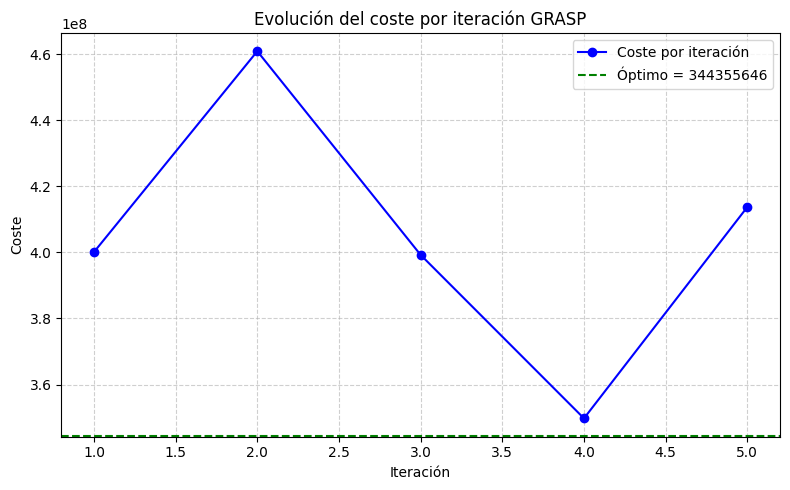

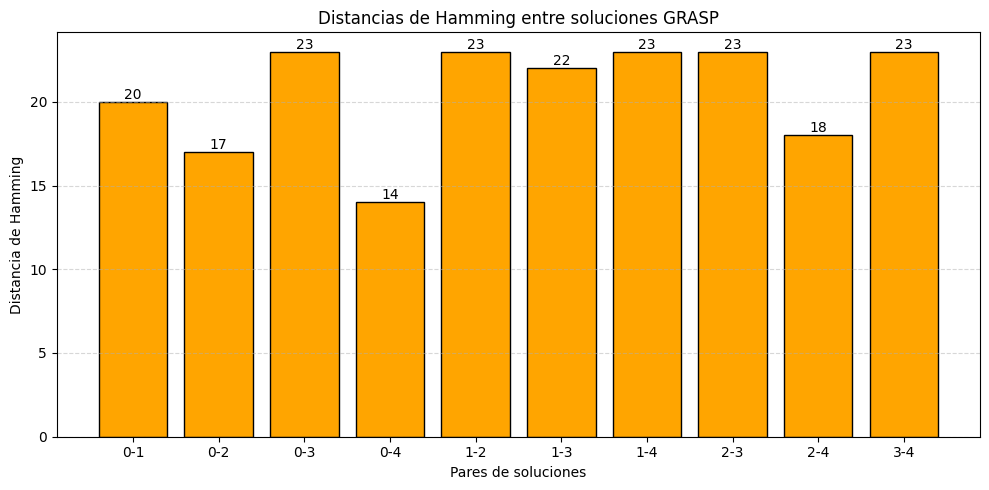

In [31]:

def plot_evolucion_coste(soluciones_con_valor, optimo=None):
    """
    Dibuja la evolución del valor objetivo por iteración y marca el valor óptimo con una línea horizontal.
    
    :param soluciones_con_valor: lista de tuplas (solución, valor)
    :param optimo: valor óptimo conocido (opcional)
    """
    valores = [v for _, v in soluciones_con_valor]
    iteraciones = list(range(1, len(valores) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(iteraciones, valores, marker='o', linestyle='-', color='blue', label='Coste por iteración')

    if optimo is not None:
        plt.axhline(y=optimo, color='green', linestyle='--', linewidth=1.5, label=f'Óptimo = {optimo}')

    plt.title("Evolución del coste por iteración GRASP")
    plt.xlabel("Iteración")
    plt.ylabel("Coste")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_distancias_hamming(soluciones_con_valor):
    """
    Muestra las primeras top_n distancias de Hamming entre pares de soluciones, en orden de aparición.
    """
    soluciones = [s for s, _ in soluciones_con_valor]
    distancias = []
    etiquetas = []

    n = len(soluciones)

    for i in range(n):
        for j in range(i + 1, n):
            d = sum(a != b for a, b in zip(soluciones[i], soluciones[j]))
            distancias.append(d)
            etiquetas.append(f"{i}-{j}")

    # Graficar
    plt.figure(figsize=(10, 5))
    plt.bar(etiquetas, distancias, color='orange', edgecolor='black')
    plt.title(f"Distancias de Hamming entre soluciones GRASP")
    plt.xlabel("Pares de soluciones")
    plt.ylabel("Distancia de Hamming")
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Mostrar valor encima de cada barra
    for i, val in enumerate(distancias):
        plt.text(i, val, str(val), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

optimos = {
    25: 344355646,
    90: 115534,
    150: 498896643
}

soluciones_valores = GRASP_results[25]['soluciones']
plot_evolucion_coste(soluciones_valores, optimo=optimos[25])
plot_distancias_hamming(soluciones_valores)


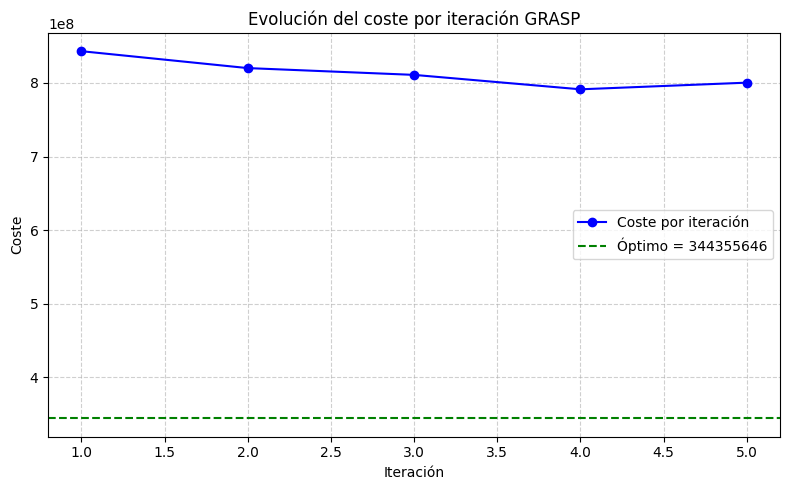

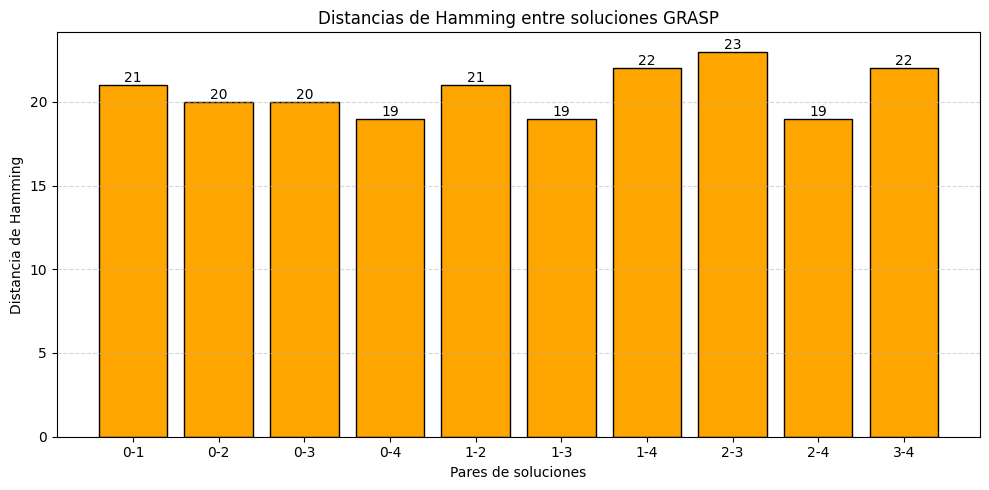

In [34]:
####### Comparacion entre GRASP y GRASP puro
GRASP_puro_results = dict()

for d in [tai25]: # Datasets QAP
    n = d['distancia'].shape[0]
    matD = d['distancia']
    matF = d['flujo']
    
    seeds = [42, 420, 4200, 42000, 80987]
    subdict = dict() 
    # GRASP
    l = int(np.round(0.1 * n))
    solucion, valor, _, soluciones = GRASP_puro(matD, matF, l, seeds)

    subdict['solucion'] = solucion
    subdict['valor'] = valor
    #subdict['evaluaciones'] = evaluaciones
    subdict['soluciones'] = soluciones

    GRASP_puro_results[n] = subdict

soluciones_valores = GRASP_puro_results[25]['soluciones']
plot_evolucion_coste(soluciones_valores, optimo=optimos[25])
plot_distancias_hamming(soluciones_valores)

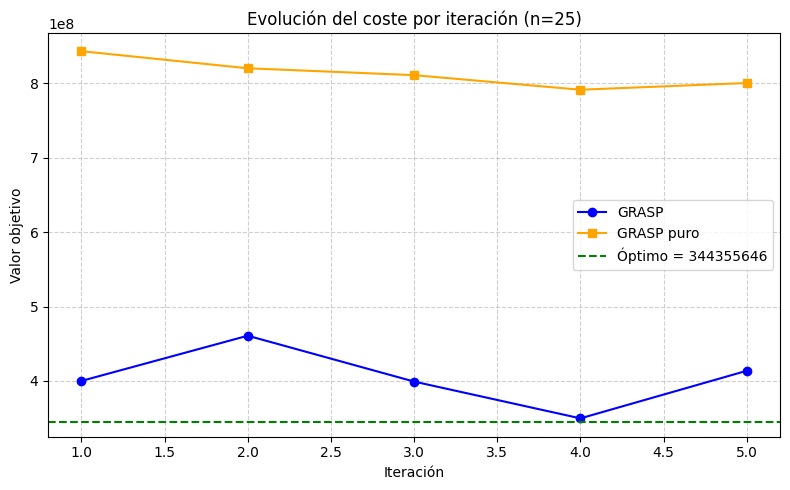

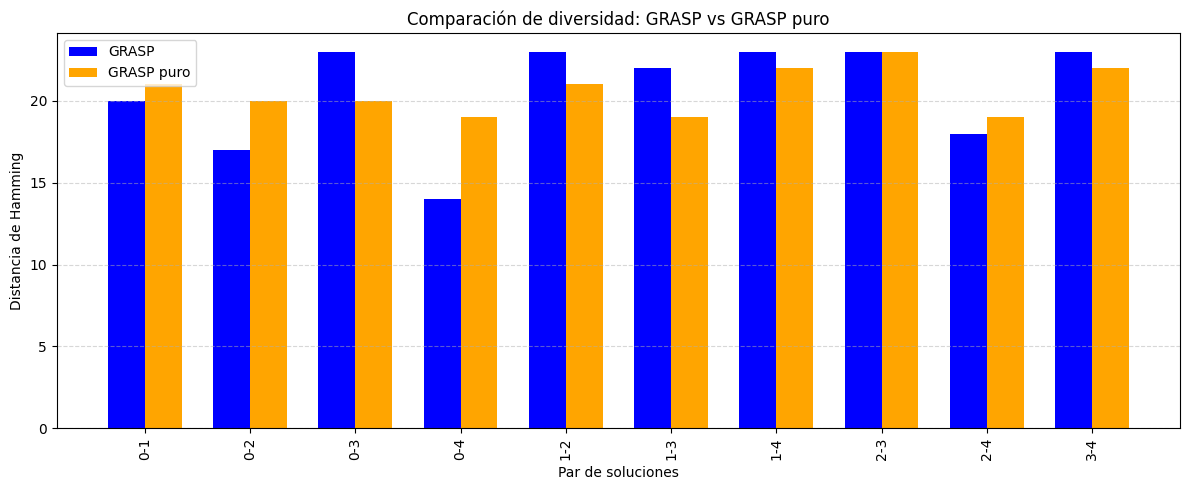

In [38]:
def plot_evoluciones_comparadas(soluciones_grasp, soluciones_grasp_puro, optimo, titulo=""):
    """
    Dibuja la evolución del coste por iteración para GRASP y GRASP puro, con línea de óptimo.
    
    :param soluciones_grasp: lista de (solución, valor) para GRASP+BL
    :param soluciones_grasp_puro: lista de (solución, valor) para GRASP puro
    :param optimo: valor óptimo conocido
    :param titulo: título opcional del gráfico
    """
    valores_grasp = [v for _, v in soluciones_grasp]
    valores_puro = [v for _, v in soluciones_grasp_puro]
    iteraciones = list(range(1, len(valores_grasp) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(iteraciones, valores_grasp, marker='o', linestyle='-', label='GRASP', color='blue')
    plt.plot(iteraciones, valores_puro, marker='s', linestyle='-', label='GRASP puro', color='orange')
    plt.axhline(y=optimo, color='green', linestyle='--', label=f'Óptimo = {optimo}')

    plt.title(f"Evolución del coste por iteración {titulo}")
    plt.xlabel("Iteración")
    plt.ylabel("Valor objetivo")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_comparacion_diversidad_hamming(soluciones_grasp, soluciones_grasp_puro):
    """
    Muestra distancias de Hamming agrupadas por par de soluciones, comparando GRASP y GRASP puro.
    Se asume que ambos sets tienen el mismo número de soluciones y en el mismo orden.
    """
    sols_g = [s for s, _ in soluciones_grasp]
    sols_p = [s for s, _ in soluciones_grasp_puro]

    assert len(sols_g) == len(sols_p), "GRASP y GRASP puro deben tener el mismo número de soluciones."

    etiquetas = []
    valores_grasp = []
    valores_puro = []

    n = len(sols_g)
    for i in range(n):
        for j in range(i + 1, n):
            etiqueta = f"{i}-{j}"
            etiquetas.append(etiqueta)
            valores_grasp.append(sum(a != b for a, b in zip(sols_g[i], sols_g[j])))
            valores_puro.append(sum(a != b for a, b in zip(sols_p[i], sols_p[j])))

    x = np.arange(len(etiquetas))  # posiciones
    width = 0.35  # ancho de barra

    plt.figure(figsize=(max(12, len(x) * 0.4), 5))
    plt.bar(x - width/2, valores_grasp, width, label='GRASP', color='blue')
    plt.bar(x + width/2, valores_puro, width, label='GRASP puro', color='orange')

    plt.xticks(x, etiquetas, rotation=90)
    plt.xlabel("Par de soluciones")
    plt.ylabel("Distancia de Hamming")
    plt.title("Comparación de diversidad: GRASP vs GRASP puro")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


n = 25
sols_grasp = GRASP_results[n]['soluciones']
sols_puro = GRASP_puro_results[n]['soluciones']

plot_evoluciones_comparadas(sols_grasp, sols_puro, optimo=optimos[n], titulo=f"(n={n})")
plot_comparacion_diversidad_hamming(sols_grasp, sols_puro)